In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import networkx as nx
from rivnet import (get_distance_along_river_using_fmm,
                    get_distance_segments,
                    get_undirected_river_network,
                    direct_river_network_using_distance,
                    export_edges_to_geodataframe,
                    export_nodes_to_geodataframe,
                    get_map_centroid_from_binary_mask,
                    apply_func_to_superpixels,
                    get_array_from_features,
                    get_width_features_from_segments,
                    add_widths_to_graph,
                    )
from skimage.color import label2rgb
import random
from shapely.geometry import Point
import geopandas as gpd
import scipy.ndimage as nd
from scipy.ndimage import find_objects


# Initialize Paths for Data And Output

In [2]:
map_name = 'stamen_terrain_12'  # options are `stamen_terrain_12` or `google_16`
data_path = Path(f'data/{map_name}')

In [3]:
product_dir = Path('products')
products_for_map_dir = product_dir/map_name
products_for_map_dir.exists()

True

# Read Data

In [4]:
with rasterio.open(products_for_map_dir/'water_mask.tif') as ds:
    water_mask = ds.read(1)
    transform = ds.transform
transform

Affine(30.0, 0.0, 640830.0,
       0.0, -30.0, 3285240.0)

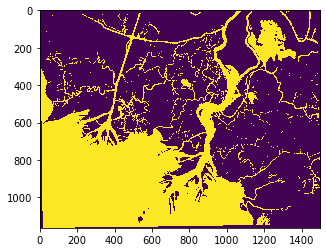

In [5]:
plt.imshow(water_mask)

In [6]:
with rasterio.open(products_for_map_dir/'ocean_mask.tif') as ds:
    ocean_mask = ds.read(1)
    profile = ds.profile

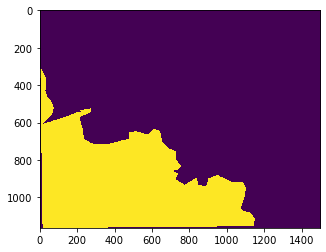

In [7]:
plt.imshow(ocean_mask)

We are going to get the resolution distance in the upper right corner (origin). Of course, this is not valid through the entire raster. The fast-marching method will use this `dx, dy` to approximate distance to our initialization mask (namely the ocean). We will update this distance at the end.

In [8]:
dx, dy = transform.a, -transform.e
dx, dy

(30.0, 30.0)

In [9]:
dist = get_distance_along_river_using_fmm(water_mask,
                                          ocean_mask,
                                          dx=dx,
                                          dy=dy,
                                          # removes areas with less than 2.5% of total size
                                          area_threshold=.025
                                          )

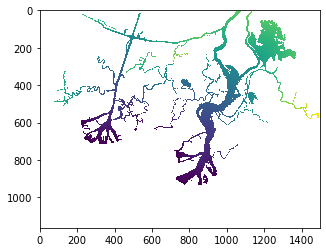

In [10]:
plt.imshow(dist)

We write the distance raster.

In [11]:
p = profile.copy()
p['dtype'] = 'float32'
with rasterio.open(products_for_map_dir/'distance.tif', 'w', **p) as ds:
    ds.write(dist.astype(np.float32), 1)

We threshold the distance according to some number of pixels - below we use `pixel_step`.

In [12]:
pixel_step = 10

segments, interface_adj_segments = get_distance_segments(dist,
                                                         pixel_step,
                                                         dx=dx,
                                                         dy=dy)

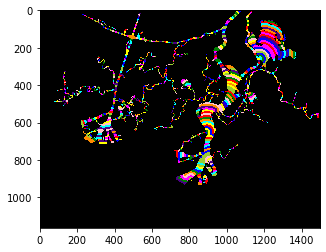

In [13]:
segments_rgb = label2rgb(segments, bg_label=0)
plt.imshow(segments_rgb)

In [14]:
p = profile.copy()
p['dtype'] = 'int32'
with rasterio.open(products_for_map_dir/'segments.tif', 'w', **p) as ds:
    ds.write(segments.astype(np.int32), 1)

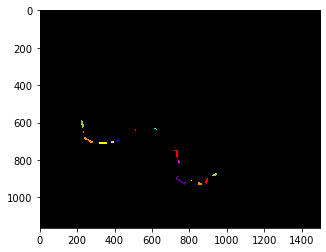

In [15]:
segment_interface_slice = np.isin(segments, interface_adj_segments)
segments_along_interface = segments.copy()
segments_along_interface[~segment_interface_slice] = 0

# To get same color scheme from above
ind = (segments_along_interface != 0)
interface_rgb = np.zeros(segments_rgb.shape)
interface_rgb[ind] = segments_rgb[ind]
plt.imshow(interface_rgb)

In [16]:
p = profile.copy()
p['dtype'] = 'int32'
with rasterio.open(products_for_map_dir/'segments_along_interface.tif', 'w', **p) as ds:
    ds.write(segments_along_interface.astype(np.int32), 1)

# Making an Undirected Network

In [17]:
rivG_undirected = get_undirected_river_network(segments, dist, profile, interface_adj_segments)

adding edges: 100%|██████████| 1238/1238 [00:00<00:00, 179940.69it/s]


In [18]:
type(rivG_undirected)

networkx.classes.graph.Graph

In [19]:
node_data =dict(rivG_undirected.nodes(data=True))
random.choice(list(node_data.items()))

((652485.0, 3271174.5),
 {'label': 720,
  'meters_to_interface': 7319.765625,
  'x': 652485.0,
  'y': 3271174.5,
  'interface_adj': False})

In [20]:
edge_data =(rivG_undirected.edges(data=True))
edge_data = {(e[0], e[1]): e[2] for e in edge_data}
random.choice(list(edge_data.items()))

(((667425.0, 3260400.0), (667437.8181818182, 3260219.4545454546)),
 {'length_m': 180.99990867990743, 'weight': 180.99990867990743})

/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


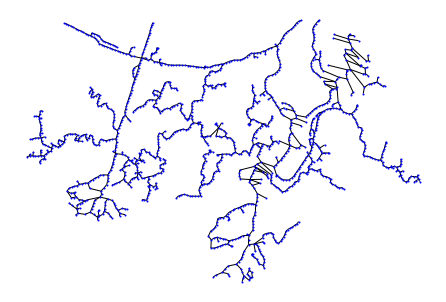

In [21]:
pos = {node: node for node in node_data.keys()}
nx.draw(rivG_undirected, 
        pos=pos, 
        node_size=1, 
        node_color='blue')
plt.show()


# A Directed Network

In [22]:
rivG = direct_river_network_using_distance(rivG_undirected, 
                                           remove_danlging_segments=True, 
                                           segment_threshold=3,
                                           meters_to_interface_filter_buffer=1_000,
                                          )

In [23]:
import numpy as np
xx = np.array([np.nan, 2, 3]).reshape((-1, 1))
np.argwhere(xx[1:] > 1) + 1

array([[1, 1],
       [2, 1]])

/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


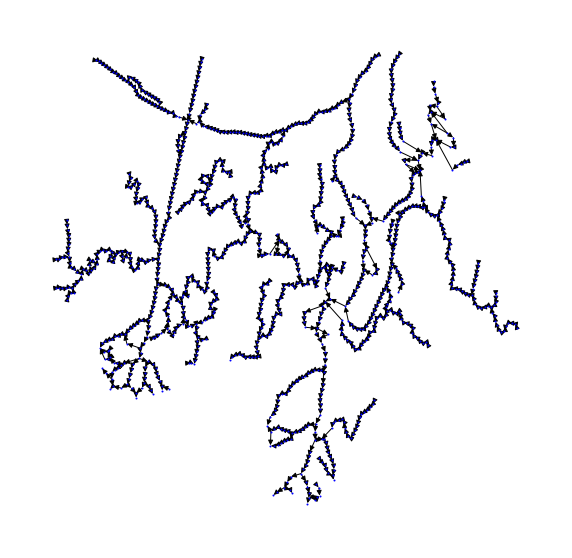

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(rivG, 
        pos=pos, 
        node_size=1,
        arrows=True,
        arrowsize=10,
        ax=ax,
        node_color='blue')
plt.show()

Once these are exported to `geojson` format below - we can view these including the arrows as indicated [here](https://gis.stackexchange.com/a/215842/114646).

In [25]:
str(profile['crs']).lower()

'epsg:32615'

In [26]:
df_edges = export_edges_to_geodataframe(rivG, profile)
df_edges.head()

,length_m,weight,segment_id,edges_in_segment,cc_id,geometry
0,288.334858,288.334858,0,8,0,LINESTRING (649828.6633663366 3267821.88118811...
1,306.922814,306.922814,0,8,0,LINESTRING (649540.4651162791 3267830.75581395...
2,325.897206,325.897206,0,8,0,"LINESTRING (649246 3267744.2, 648922.459016393..."
3,289.764128,289.764128,0,8,0,LINESTRING (648922.4590163934 3267705.08196721...
4,315.175747,315.175747,0,8,0,LINESTRING (648685.9574468085 3267537.65957446...


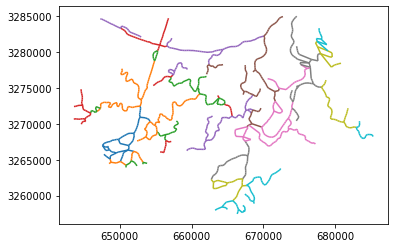

In [27]:
df_edges.plot(column='segment_id', categorical=True)

# Draw Interface Sink

We are going to add a node in the middle of the ocean that will can be visualized as a sink.

In [28]:
ocean_centroid = get_map_centroid_from_binary_mask(ocean_mask, profile)
ocean_centroid

(654490.5670718786, 3257680.4263715236)

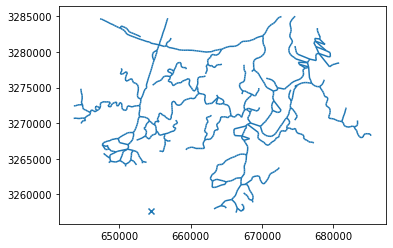

In [29]:
fig, ax = plt.subplots()
df_ocean_centroid = gpd.GeoDataFrame(geometry=[Point(ocean_centroid)],
                                     crs={'init':'epsg:4326'})
df_edges.plot(ax=ax)
df_ocean_centroid.plot(ax=ax, marker='x')

In [30]:
connected_to_interface = [node for node in rivG.nodes() if (rivG.nodes[node]['interface_adj'])]
rivG_sink = rivG.copy()

edge_data_to_interface = {(node, ocean_centroid): {'weight': 0,
                                                   'meters_to_interface': 0} for node in connected_to_interface}

rivG_sink.add_edges_from(edge_data_to_interface.keys())

nx.set_edge_attributes(rivG_sink, edge_data_to_interface)

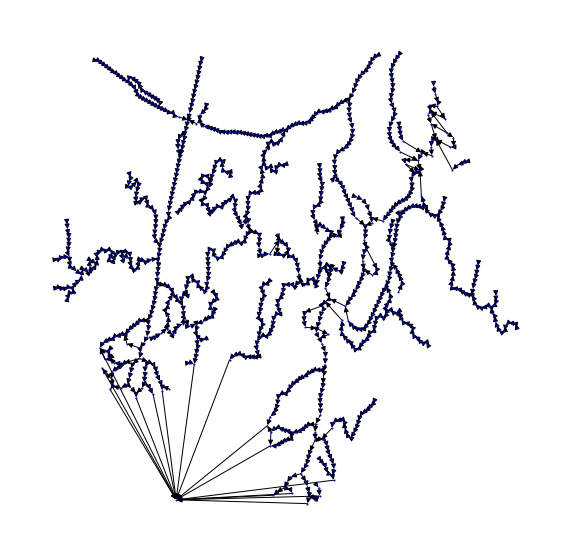

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))
pos[ocean_centroid] = ocean_centroid

nx.draw(rivG_sink, 
        pos=pos, 
        node_size=1,
        arrows=True,
        arrowsize=10,
        ax=ax,
        node_color='blue')
plt.show()

# Including Widths

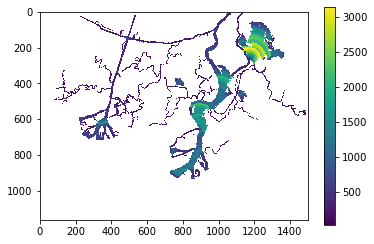

In [32]:
width_features = get_width_features_from_segments(segments, profile)
widths = get_array_from_features(segments, width_features)
plt.imshow(widths)
plt.colorbar()

In [33]:
rivG = add_widths_to_graph(rivG, width_features.ravel())

In [34]:
p = profile.copy()
p['dtype'] = 'float32'
with rasterio.open(products_for_map_dir/'widths.tif', 'w', **p) as ds:
    ds.write(widths.astype(np.float32), 1)

# Save Network

First, we export each of the graphs to Geopandas `GeoDataFrame`.

In [35]:
df_nodes = export_nodes_to_geodataframe(rivG, profile)
df_edges = export_edges_to_geodataframe(rivG, profile)

For example, the edge attributes are now columns in a dataframe.

In [36]:
df_edges.head()

,length_m,weight,segment_id,edges_in_segment,cc_id,geometry
0,288.334858,288.334858,0,8,0,LINESTRING (649828.6633663366 3267821.88118811...
1,306.922814,306.922814,0,8,0,LINESTRING (649540.4651162791 3267830.75581395...
2,325.897206,325.897206,0,8,0,"LINESTRING (649246 3267744.2, 648922.459016393..."
3,289.764128,289.764128,0,8,0,LINESTRING (648922.4590163934 3267705.08196721...
4,315.175747,315.175747,0,8,0,LINESTRING (648685.9574468085 3267537.65957446...


We save these using the geopandas ecosystem. We used `geojson` because some of our column names are long and shapefiles have a 10 character limit. However, removing the `driver` keyword (the shapefile is default), saves the above dataframe to an ESRI Shapfile.

In [37]:
df_edges.to_file(products_for_map_dir/'rivnet_edges.geojson', driver='GeoJSON')
df_nodes.to_file(products_for_map_dir/'rivnet_nodes.geojson', driver='GeoJSON')
nx.write_gpickle(rivG, products_for_map_dir/'river_network.pkl')

And if you wish to check the direction of flow in QGIS, use this [feature](https://gis.stackexchange.com/a/215842/114646). 